In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip gdrive/My\ Drive/covidandnorm.zip

Archive:  gdrive/My Drive/covidandnorm.zip
replace COVID-19_DATASET_2_CLASSES/README.md.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 15 21:55:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
train_data_dir = '/content/COVID-19_DATASET_2_CLASSES/train'

In [ ]:
valid_data_dir = '/content/COVID-19_DATASET_2_CLASSES/val'

In [ ]:
test_data_dir = '/content/COVID-19_DATASET_2_CLASSES/test'# Set the number of classes
num_classes = 2  # COVID-19 positive and negative

# Set the input image size for VGG19
# input_shape = (70, 70, 3)
input_shape = (224, 224, 3)
# Set the batch size and number of epochs
batch_size = 32
EPOCHS = 100


In [ ]:
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)


In [ ]:
valid_test_data_gen = ImageDataGenerator(rescale=1./255)


In [ ]:

input_shape = (224, 224, 3)
model = Sequential()
model.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', input_shape = input_shape))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(Flatten())
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dropout(0.3))

model.add(Dense(2,activation = 'sigmoid'))
model.compile( loss = 'binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 111, 111, 128)    0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 111, 111, 128)     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 54, 54, 64)       

In [ ]:
train_generator = train_data_gen.flow_from_directory(
    train_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

Found 5426 images belonging to 2 classes.


In [ ]:
valid_generator = valid_test_data_gen.flow_from_directory(
    valid_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1446 images belonging to 2 classes.


In [ ]:
test_generator = valid_test_data_gen.flow_from_directory(
    test_data_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 360 images belonging to 2 classes.


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=EPOCHS,  # Set a large number of epochs, EarlyStopping will stop training if there is no improvement
    validation_data=valid_generator,
    validation_steps=valid_generator.n // batch_size,
    callbacks=[early_stopping]  # Add the EarlyStopping callback
)


Epoch 1/100
169/169 [==============================] - 119s 571ms/step - loss: 0.6615 - accuracy: 0.5803 - val_loss: 0.7061 - val_accuracy: 0.5486
Epoch 2/100
169/169 [==============================] - 95s 558ms/step - loss: 0.5464 - accuracy: 0.6945 - val_loss: 0.6797 - val_accuracy: 0.5396
Epoch 3/100
169/169 [==============================] - 86s 511ms/step - loss: 0.5280 - accuracy: 0.6982 - val_loss: 0.7216 - val_accuracy: 0.5125
Epoch 4/100
169/169 [==============================] - 85s 502ms/step - loss: 0.5286 - accuracy: 0.6926 - val_loss: 0.6930 - val_accuracy: 0.5056
Epoch 5/100
169/169 [==============================] - 86s 509ms/step - loss: 0.5064 - accuracy: 0.7026 - val_loss: 0.6605 - val_accuracy: 0.5597
Epoch 6/100
169/169 [==============================] - 86s 509ms/step - loss: 0.5040 - accuracy: 0.7106 - val_loss: 0.6682 - val_accuracy: 0.5431
Epoch 7/100
169/169 [==============================] - 85s 502ms/step - loss: 0.5006 - accuracy: 0.7245 - val_loss: 0.6845 

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

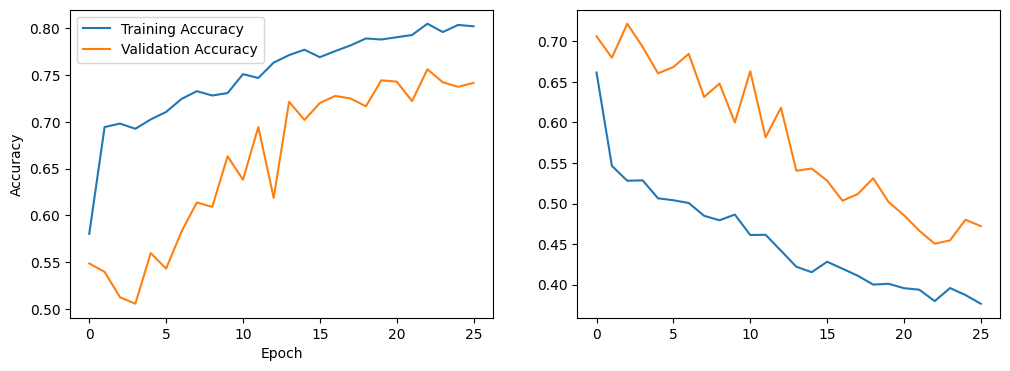

In [ ]:
# Plot training accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel

In [ ]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.n // batch_size)
print('Test accuracy:', test_acc)

<ipython-input-55-11f23487ccdf>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.n // batch_size)


Test accuracy: 0.8835227489471436


In [ ]:
test_generator.reset()
y_pred = model.predict_generator(test_generator)
y_true = test_generator.classes
y_pred = np.argmax(y_pred, axis=1)

<ipython-input-56-a59a225fbba3>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(test_generator)


In [ ]:
class_labels = list(test_generator.class_indices.keys())
classification_rep = classification_report(y_true, y_pred, target_names=class_labels)
print('Classification Report:')
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

       COVID       0.84      0.94      0.89       180
      Normal       0.93      0.83      0.88       180

    accuracy                           0.88       360
   macro avg       0.89      0.88      0.88       360
weighted avg       0.89      0.88      0.88       360



In [ ]:
model.save('/content/gdrive/MyDrive/606_Covid19_project/Saved_models/custom_32b_covid')

In [ ]:
def model_predict(img):
    arr_img = tf.keras.utils.img_to_array(img)
    arr_img = np.expand_dims(arr_img, axis = 0)

    # Preprocess the input using VGG-16's preprocess_input() method.
    arr_img_processed = preprocess_input(arr_img)
    
    # Perform prediction.
    result = model.predict(arr_img_processed)


    plt.figure()
    plt.imshow(img)
    print("Prediction Result:")
    print("Class\t\t\t", "Prediction")
    print("COVID\t\t\t", result[0][0] * 100)
    print("Normal\t\t\t", result[0][1] * 100)
    if(result[0][0]<.50):
        result="normal"
    else:
        result="corona positive"
    print("Prediction Result: ", result)

In [ ]:
norm_path = '/content/COVID-19_DATASET_2_CLASSES/test/Normal/Normal-57.png'
cov_path = '/content/COVID-19_DATASET_2_CLASSES/test/COVID/COVID-31.png'

1/1 [==============================] - 0s 103ms/step
Prediction Result:
Class			 Prediction
COVID			 0.0
Normal			 100.0
Prediction Result:  normal


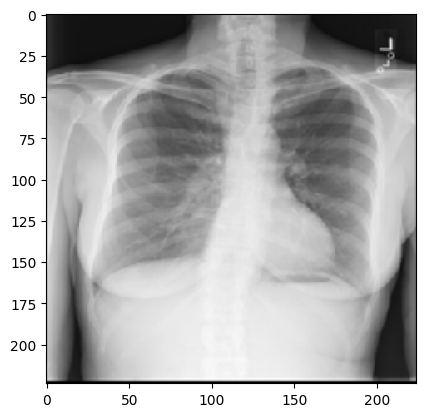

In [ ]:
test_img = tf.keras.utils.load_img(norm_path, target_size = (224, 224))
model_predict(test_img)